In [ ]:
# get data from google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/ 

/content/drive/My Drive


### Install All Requirements

In [ ]:
import os
import cv2 #opencv image processing
import time # Runtime calculation
import shutil 
import itertools
import tensorflow # Deep Learning Frameworks
import numpy as np  # Mathematical and Array Operations
import pandas as pd# Data Frame Operations
from PIL import Image # Python Imaging Library
import seaborn as sns # Visualization library
import matplotlib.pyplot as plt  # Visualization library

# Deep Learning API functionalities
from tensorflow.keras.models import Model 
from sklearn.metrics import confusion_matrix # Confusion matrix for model evaluation 
from tensorflow.keras.models import Sequential # Sequential model initialization
from sklearn.model_selection import train_test_split  # function to split sample data to train and test
from tensorflow.keras.optimizers import Adam, Nadam, Ftrl # Optimizer algorithms
from tensorflow.keras.metrics import categorical_crossentropy  # Loss functions
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For data pipeline building

# Neural network layers
import tensorflow as tf
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,AveragePooling2D

# To prevent Over-fitting
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [ ]:
# display number of images in each file 
for dirpath , dirnames , filenames in os.walk('/content/drive/MyDrive/data'):
  print(f'There are {len(dirnames)} dirctory and {len(filenames)} images in "{dirpath}" .')

There are 2 dirctory and 0 images in "/content/drive/MyDrive/data" .
There are 2 dirctory and 0 images in "/content/drive/MyDrive/data/test" .
There are 0 dirctory and 360 images in "/content/drive/MyDrive/data/test/benign" .
There are 0 dirctory and 300 images in "/content/drive/MyDrive/data/test/malignant" .
There are 2 dirctory and 0 images in "/content/drive/MyDrive/data/train" .
There are 0 dirctory and 1440 images in "/content/drive/MyDrive/data/train/benign" .
There are 0 dirctory and 1197 images in "/content/drive/MyDrive/data/train/malignant" .


In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random 

def get_number_image(target_dir , target_class, number):
  target_folder = target_dir + target_class
  #get random image path 
  random_images = random.sample(os.listdir(target_folder),number)
  return random_images ,target_folder 

def veiw_random_images(target_dir , target_class, number):
  
  plt.figure(figsize=(10,5))
  # veiw and plot image 
  random_image, target_folder= get_number_image(target_dir , target_class, number)
  for i in range(number):
    plt.subplot(number/2, (number/2)+1,i+1)
    img = mpimg.imread(target_folder + '/' + random_image[i])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
  

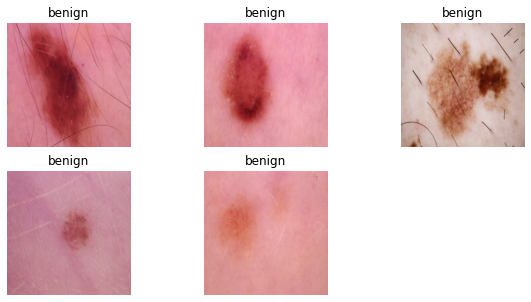

In [ ]:
veiw_random_images('/content/drive/MyDrive/data/train/', 'benign',5)

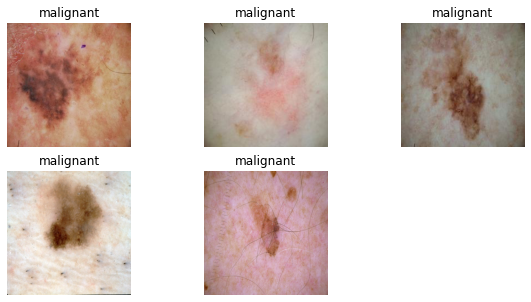

In [ ]:
veiw_random_images('/content/drive/MyDrive/data/train/', 'malignant',5)

### 2 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def check_for_leakage(trainPath, testPath):
    """
    Return True if there any patients are in both df1 and df2.
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(os.listdir(trainPath))
    df2_patients_unique = set(os.listdir(testPath))
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) !=0 # boolean (true if there is at least 1 patient in both groups)
    
    ### END CODE HERE ###
    
    return leakage

In [ ]:
# define the path of the data 
trainPathBenign = '/content/drive/MyDrive/data/train/benign'
testPathBenign = '/content/drive/MyDrive/data/test/benign'

trainPathMalignant = '/content/drive/MyDrive/data/train/malignant'
testPathMalignant = '/content/drive/MyDrive/data/test/malignant'

# check for leakage 
print("leakage between train and valid: {}".format(check_for_leakage(trainPathBenign, testPathBenign)))
print("leakage between train and test: {}".format(check_for_leakage(trainPathMalignant, testPathMalignant)))



leakage between train and valid: False
leakage between train and test: False


### class Balanced 
check the balance of the number of each class

In [ ]:
trainPathBenign = os.listdir(trainPathBenign)
testPathBenign = os.listdir(testPathBenign)
benign = len(trainPathBenign) + len(testPathBenign)
benign

1800

In [ ]:
trainPathMalignant = os.listdir(trainPathMalignant)
testPathMalignant = os.listdir(testPathMalignant)
Malignant = len(trainPathMalignant) + len(testPathMalignant)
Malignant



1497

In [ ]:
val_count = [benign, Malignant]
val_count = pd.DataFrame(data=val_count,columns=['num'])
val_count


,num
0,1800
1,1497


Text(0.5, 1.0, 'class Data Distribution')

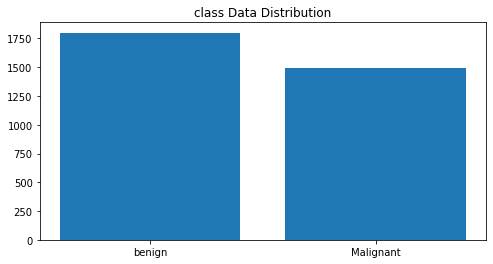

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.num ,tick_label=['benign','Malignant'])
plt.title("class Data Distribution")

### CNN Model

In [ ]:
# set random seed
tf.random.set_seed(42)

#set path to our data dirctionary 
train_dir = '/content/drive/MyDrive/data/train'
test_dir = '/content/drive/MyDrive/data/test'

#processed data(all pixel of the image between 0 & 1 also called normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

#import data from directory and turn it into patches 
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               seed=42,
                                               class_mode="binary")

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               seed=42,
                                               class_mode="binary")


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
file_location = "model.h5"
# A feature of CallBack API that keeps track of performance of the model and stores the best performaces at different time steps.
checkpoint = ModelCheckpoint(file_location,monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')

In [ ]:
#bulid CNN model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10 ,3 , activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,padding='valid'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2),
     tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')

])

#compile our model 
model_1.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

#fit our model
history_1 = model_1.fit( train_data, 
          epochs=30,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data),callbacks= [checkpoint])

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.6754 
Epoch 1: val_accuracy improved from -inf to 0.75606, saving model to model.h5
83/83 [==============================] - 2353s 28s/step - loss: 0.5871 - accuracy: 0.6754 - val_loss: 0.5767 - val_accuracy: 0.7561
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.5201 - accuracy: 0.7421
Epoch 2: val_accuracy improved from 0.75606 to 0.75909, saving model to model.h5
83/83 [==============================] - 12s 143ms/step - loss: 0.5201 - accuracy: 0.7421 - val_loss: 0.4536 - val_accuracy: 0.7591
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.7789
Epoch 3: val_accuracy improved from 0.75909 to 0.78485, saving model to model.h5
83/83 [==============================] - 13s 151ms/step - loss: 0.4509 - accuracy: 0.7789 - val_loss: 0.4171 - val_accuracy: 0.7848
Epoch 4/30
83/83 [==============================] - ETA: 0s - loss: 0.4343 - accu

In [ ]:
# model_1.save('mode_cnn.h5')

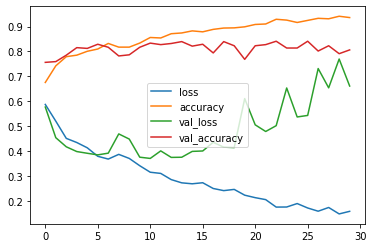

In [ ]:
import pandas as pd
DDD = pd.DataFrame(history_1.history).plot()

In [ ]:
! touch utils.py

In [ ]:
import cv2 
imga = cv2.imread('/content/drive/MyDrive/test/benign/1013.jpg')
# plt.imshow(imga)

In [ ]:
x = np.expand_dims(imga, axis=0)

In [ ]:
x.shape

(1, 224, 224, 3)

In [ ]:
x=x/255.0

In [ ]:
model_1.predict(x)

array([[0.2250379]], dtype=float32)

In [ ]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
import os


In [ ]:
def load_image(img, image_dir,  preprocess=True, H=224, W=224):
    """Load and preprocess image."""
    # mean, std = get_mean_std_per_batch(image_dir, df, H=H, W=W)
    img_path = os.path.join(image_dir, img)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        
        x = np.expand_dims(x, axis=0)
    return x
def grad_cam(input_model, image, cls, layer_name, H=224, W=224):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam



def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir,  preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir,  preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals



In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model.h5')

In [ ]:
n= load_image('100.jpg','/content/drive/MyDrive/data/train/benign')



In [ ]:
n.shape

(1, 224, 224, 3)

In [ ]:
model.predict(n)

array([[0.]], dtype=float32)